<a href="https://colab.research.google.com/github/Smarties123/bio-inspired-cwk2-web/blob/main/research/Bio_Inspired_CWK_2_Final_Version_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bio Inspired CWK 2 Final Version - MNIST

## 01 Imports & global config


In [19]:
!pip -q install minisom scikit-image ipympl

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00


In [20]:
import numpy as np, matplotlib.pyplot as plt
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
from minisom import MiniSom
from collections import defaultdict
np.random.seed(42)

IMG             = 28      # MNIST image size
NOISE_LEVELS    = [0,10,20,30,40,50,60,70,80,90,95]
STEPS_HOPFIELD  = 15
STEPS_CA        = 15



## 02 | Data & helper functions

This section handles loading the MNIST dataset and preparing reference digit patterns for experiments with associative memory models.





In [21]:
to_tensor = transforms.ToTensor()                 # keeps 0-1 floats
mnist = datasets.MNIST(root=".", train=True, download=True,
                       transform=to_tensor)

# one reference digit per class
patterns, labels, seen = [], [], set()
for x, y in mnist:
    if y not in seen:
        patterns.append(x.view(-1).numpy())       # 784-D vector, 0–1
        labels.append(int(y)); seen.add(y)
    if len(seen)==10: break
patterns = np.stack(patterns).astype(np.float32)

# ------- utilities -------
def to_pm1(x): return x*2 - 1           # 0-1 ➜ –1…1
def to_01(x): return (x+1)/2            # –1…1 ➜ 0-1

def add_noise(x, pct):
    """Salt-and-pepper noise (works for binary or grayscale 0–1)."""
    x = x.copy()
    n = int(len(x)*pct/100)
    idx = np.random.choice(len(x), n, replace=False)
    x[idx] = 1 - x[idx]                # flip intensity
    return x

def mse_ssim(rec, ref):
    img_r, img_t = rec.reshape(IMG,IMG), ref.reshape(IMG,IMG)
    return ((img_r - img_t)**2).mean(), ssim(img_t, img_r, data_range=1)


100%|██████████| 9.91M/9.91M [00:00<00:00, 32.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.84MB/s]


## 03 Original models

This section implements three biologically inspired associative memory models (Hopfield network, Majority Cellular Automaton, and Self-Organizing Map), plus a hybrid Local-Attractor Memory (LAM) model.

The LAM model combines a Hopfield network and a Cellular Automaton to perform multi-stage memory recall. First, the Hopfield network retrieves a global pattern from noisy input; then the CA refines it by denoising local pixel-level noise. This mimics biological memory consolidation through global recall followed by local repair.










In [22]:
# --- Hopfield Network ---
class Hopfield:
    def __init__(self, pats01):
        # Convert patterns from [0,1] to [-1,+1] and compute Hebbian weights
        P, N = to_pm1(pats01), pats01.shape[1]
        W = np.sum([np.outer(p, p) for p in P], axis=0)  # outer-product rule
        np.fill_diagonal(W, 0)  # no self-connections
        self.W = W / N          # normalize by number of neurons

    def recall(self, x01, steps=STEPS_HOPFIELD):
        # Iteratively apply sign activation to recover memory
        x = to_pm1(x01)
        for _ in range(steps):
            x = np.sign(self.W @ x)   # synchronous update
            x[x == 0] = 1             # resolve ties arbitrarily
        return to_01(x)


# --- Majority Cellular Automaton ---
class MajorityCA:
    def step(self, g):
        # Apply majority rule to each pixel using 3x3 neighborhood
        pad = np.pad(g, 1, mode='wrap')
        s = sum(pad[1+dy:1+dy+IMG, 1+dx:1+dx+IMG]
                for dy in (-1, 0, 1) for dx in (-1, 0, 1))
        return (s >= 5).astype(float)  # threshold at majority (5/9)

    def recall(self, x01, steps=STEPS_CA):
        # Denoise image using repeated CA steps
        g = x01.reshape(IMG, IMG)
        for _ in range(steps):
            g = self.step(g)
        return g.reshape(-1)


# --- Self-Organizing Map (MiniSOM wrapper) ---
class SOMWrap:
    def __init__(self, pats01, m=20, n=20):
        # Train SOM grid on clean patterns
        self.som = MiniSom(m, n, pats01.shape[1], sigma=4, learning_rate=0.5)
        self.som.random_weights_init(pats01)
        self.som.train_random(pats01, 1000)
        # Flatten 2D SOM grid into codebook vectors
        self.codes = self.som.get_weights().reshape(-1, pats01.shape[1])

    def recall(self, x01):
        # Return BMU (Best Matching Unit) prototype for input
        i, j = self.som.winner(x01)
        n_columns = self.som.get_weights().shape[1]
        return self.codes[i * n_columns + j]


# --- Hybrid Hopfield–CA Model ---
class LAM:
    def __init__(self, hop, ca):
        # Store Hopfield and CA modules
        self.hop, self.ca = hop, ca

    def recall(self, x01):
        # Perform global Hopfield recall, then local CA refinement
        h = self.hop.recall(x01)
        return self.ca.recall(h)


## 04 Enhanced Models

These enhanced variants apply biologically motivated improvements to the original models to improve robustness and performance. Adjustments include smoother dynamics, short-term memory, population coding, and iterative hybrid consolidation.

Hybrid (LAMEnhanced)

Combines a few small Hopfield steps with CA-based denoising over multiple cycles, blending their outputs at each stage. This mirrors iterative biological consolidation, alternating global and local repair phases.


In [23]:
# --- Continuous Hopfield Network ---
class ContinuousHopfield:
    def __init__(self, pats01, beta=5.0):
        # Store continuous weights using Hebbian outer-product rule
        P, N = to_pm1(pats01), pats01.shape[1]
        W = np.sum([np.outer(p, p) for p in P], 0)
        np.fill_diagonal(W, 0)
        self.W, self.beta = W / N, beta

    def recall(self, x01, steps=STEPS_HOPFIELD):
        # Apply smooth tanh activation for continuous updates
        x = to_pm1(x01).astype(float)
        N = len(x)
        for _ in range(steps):
            for i in np.random.permutation(N):
                x[i] = np.tanh(self.beta * (self.W[i] @ x))
        return to_01(x)


# --- Enhanced Majority Cellular Automaton with Temporal Memory ---
class EnhancedMajorityCA:
    def __init__(self, w_prev=1.0):
        # Store the influence weight of the previous grid
        self.w_prev = w_prev

    def step(self, g, prev):
        # Include previous state (temporal memory) in neighborhood voting
        pad = np.pad(g, 1, 'wrap')
        s = sum(pad[1+dy:1+dy+IMG, 1+dx:1+dx+IMG]
                for dy in (-1, 0, 1) for dx in (-1, 0, 1))
        s += self.w_prev * prev
        return (s >= 5 + self.w_prev).astype(float)

    def recall(self, x01, steps=STEPS_CA):
        # Iteratively denoise with memory of prior state
        g, prev = x01.reshape(IMG, IMG), np.zeros((IMG, IMG))
        for _ in range(steps):
            prev, g = g, self.step(g, prev)
        return g.reshape(-1)


# --- Enhanced SOM with Local Neighborhood Averaging ---
class SOMWrapEnhanced:
    def __init__(self, pats01, m=20, n=20, noise_lvl=10):
        # Train SOM on both clean and noisy patterns
        noisy = np.array([add_noise(p, noise_lvl) for p in pats01])
        data = np.vstack([pats01, noisy])
        self.som = MiniSom(m, n, pats01.shape[1], sigma=4, learning_rate=0.5)
        self.som.random_weights_init(data)
        self.som.train_random(data, 1000)
        self.w = self.som.get_weights()  # shape (m, n, D)

    def recall(self, x01, k=1):
        # Return the average of codebook vectors in a (2k+1)x(2k+1) window
        i, j = self.som.winner(x01)
        neigh = []
        for di in range(-k, k+1):
            for dj in range(-k, k+1):
                neigh.append(self.w[(i+di)%self.w.shape[0], (j+dj)%self.w.shape[1]])
        return np.mean(neigh, axis=0)


# --- Enhanced Hybrid Hopfield–CA Model ---
class LAMEnhanced:
    def __init__(self, hop, ca, h_steps=5, c_steps=10, w=0.5, cycles=2):
        # Set up modules and parameters: hopfield/CA step counts, blend weight, cycles
        self.hop, self.ca = hop, ca
        self.hs, self.cs = h_steps, c_steps
        self.w, self.cy = w, cycles

    def recall(self, x01):
        # Alternate between global and local recall, blending after each cycle
        cur = x01.copy()
        for _ in range(self.cy):
            h = self.hop.recall(cur)              # partial Hopfield reconstruction
            c = self.ca.recall(h)                 # local CA smoothing
            cur = (1 - self.w) * h + self.w * c   # blend both outputs
        return cur


## 05 Improved Models

These improved models apply deeper algorithmic changes to overcome the limitations of earlier versions. They aim for better recall fidelity and reduced pattern interference through mechanisms like decorrelation, spatial weighting, and multi-prototype blending.

Hybrid (HybridHopCaHop)

Applies a three-stage sequence: Hopfield ➝ CA ➝ Hopfield. The first pass retrieves a global memory, the CA denoises it locally, and a final Hopfield pass sharpens the attractor convergence. This reflects cyclic consolidation of global and local memory traces.


In [24]:
# --- Hopfield Network with Pseudo-Inverse Learning ---
class HopfieldPseudoInverse:
    def __init__(self, pats01):
        # Compute decorrelated weight matrix using pseudo-inverse rule
        P = to_pm1(pats01)
        C = P @ P.T
        W = P.T @ np.linalg.inv(C) @ P
        np.fill_diagonal(W, 0)
        self.W = W / pats01.shape[0]

    def recall(self, x01, steps=STEPS_HOPFIELD):
        # Update using sign thresholding with sequential updates
        x = to_pm1(x01)
        N = len(x)
        for _ in range(steps):
            for i in np.random.permutation(N):
                x[i] = 1 if self.W[i] @ x >= 0 else -1
        return to_01(x)


# --- Weighted Majority CA (Retinal-style Kernel) ---
class WeightedMajorityCA:
    def __init__(self, kernel=None, thresh=0.5):
        # Use center-surround kernel if none provided (default is 3x3 Gaussian-like)
        self.kernel = (kernel if kernel is not None else
                       np.array([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], float) / 16)
        self.thresh = thresh

    def step(self, g):
        # Apply weighted average kernel and threshold
        pad = np.pad(g, 1, 'wrap')
        out = np.zeros_like(g)
        for i in range(IMG):
            for j in range(IMG):
                out[i, j] = (self.kernel * pad[i:i+3, j:j+3]).sum() >= self.thresh
        return out.astype(float)

    def recall(self, x01, steps=STEPS_CA):
        # Iteratively denoise using the weighted majority rule
        g = x01.reshape(IMG, IMG)
        for _ in range(steps):
            g = self.step(g)
        return g.reshape(-1)


# --- SOM-KNN: SOM with K Nearest Neighbor Averaging ---
class SOMKNN:
    def __init__(self, pats01, m=20, n=20, K=5):
        self.K = K
        self.som = MiniSom(m, n, pats01.shape[1], sigma=4, learning_rate=0.5)
        self.som.random_weights_init(pats01)
        self.som.train_random(pats01, 1000)
        self.codes = self.som.get_weights().reshape(-1, pats01.shape[1])

    def recall(self, x01):
        # Average the K closest codebook vectors in Euclidean space
        d = np.linalg.norm(self.codes - x01, axis=1)
        return self.codes[np.argsort(d)[:self.K]].mean(0)


# --- Hybrid Hopfield–CA–Hopfield Model ---
class HybridHopCaHop:
    def __init__(self, hop, ca):
        # Compose Hopfield ➝ CA ➝ Hopfield modules
        self.hop, self.ca = hop, ca

    def recall(self, x01):
        # Global recall ➝ local cleanup ➝ final sharpening
        return self.hop.recall(self.ca.recall(self.hop.recall(x01)))


## 06 Building dictionaries


In [25]:
# original
hop,ca = Hopfield(patterns), MajorityCA()
som,lam = SOMWrap(patterns), LAM(hop,ca)
models = {"Hopfield":hop,"CA":ca,"SOM":som,"LAM":lam}

# enhanced
hop_p,ca_p = ContinuousHopfield(patterns), EnhancedMajorityCA()
som_p,lam_p = SOMWrapEnhanced(patterns), LAMEnhanced(hop_p,ca_p)
enhanced_models = {"Hopfield+":hop_p,"CA+":ca_p,"SOM+":som_p,"LAM+":lam_p}

# improved
hop_pi,ca_w = HopfieldPseudoInverse(patterns), WeightedMajorityCA()
som_k,hyb2  = SOMKNN(patterns), HybridHopCaHop(hop_pi,ca_w)
improved_models = {"Hopfield-PI":hop_pi,"CA-W":ca_w,"SOM-KNN":som_k,"Hybrid2":hyb2}

all_models = {**models, **enhanced_models, **improved_models}



## 07 Benchmark – one concise table


In [26]:
import pandas as pd
records=[]
for noise in NOISE_LEVELS:
    for p in patterns:
        x_noisy = add_noise(p, noise)
        for name, m in all_models.items():
            mse,ssim_val = mse_ssim(m.recall(x_noisy), p)
            records.append(dict(Model=name, Noise=noise, MSE=mse, SSIM=ssim_val))
df = pd.DataFrame(records).groupby(["Model","Noise"]).mean().reset_index()
display(df.pivot(index="Model", columns="Noise", values="SSIM").style
        .format("{:.3f}").set_caption("Mean SSIM at each noise level"))



Noise,0,10,20,30,40,50,60,70,80,90,95
Model,,,,,,,,,,,
CA,0.532,0.461,0.375,0.285,0.211,-0.020,-0.170,-0.232,-0.253,-0.283,-0.288
CA+,0.232,0.219,0.229,0.219,0.219,0.184,-0.009,-0.138,-0.245,-0.295,-0.316
CA-W,0.881,0.810,0.627,0.347,0.139,-0.012,-0.133,-0.237,-0.310,-0.364,-0.381
Hopfield,0.373,0.373,0.373,0.373,0.373,0.157,-0.137,-0.137,-0.137,-0.137,-0.137
Hopfield+,0.373,0.373,0.373,0.373,0.373,0.242,-0.140,-0.140,-0.140,-0.140,-0.140
Hopfield-PI,0.913,0.913,0.913,0.911,0.758,0.180,-0.345,-0.412,-0.413,-0.413,-0.413
Hybrid2,0.913,0.913,0.913,0.911,0.778,0.126,-0.314,-0.413,-0.413,-0.413,-0.413
LAM,0.295,0.295,0.295,0.295,0.295,0.147,-0.062,-0.062,-0.062,-0.062,-0.062
LAM+,0.305,0.305,0.305,0.305,0.305,0.114,-0.151,-0.151,-0.151,-0.151,-0.151


## 08 Visual comparison grid (three generations)

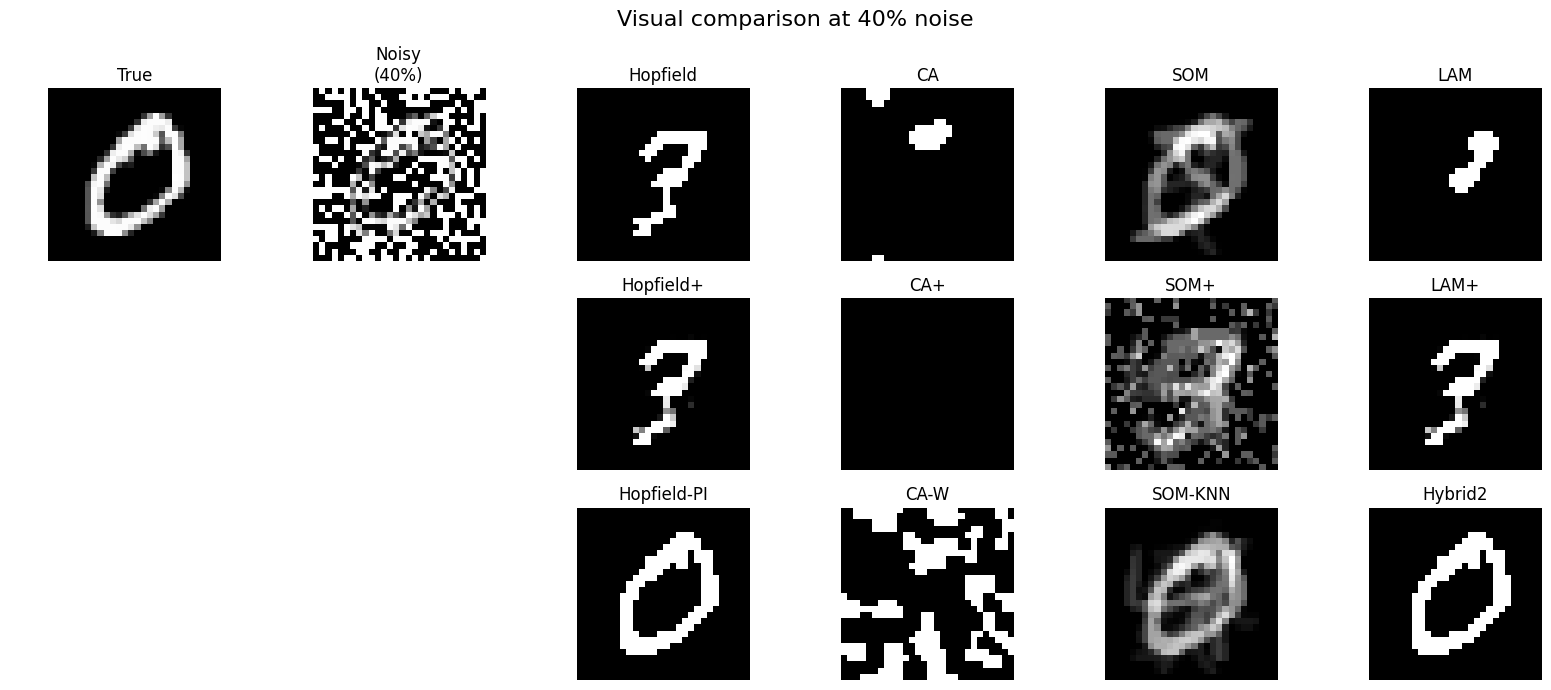

In [27]:
idx, noise = 1, 40       # choose any digit / noise %
x_true = patterns[idx]
x_noisy = add_noise(x_true, noise)

fig, ax = plt.subplots(3, len(models)+2, figsize=(16,7))
titles = ["Original", f"Noisy\n({noise}%)"] + list(models.keys())

# --- row 1: ORIGINAL ---
ax[0,0].imshow(x_true.reshape(28,28),cmap='gray'); ax[0,0].set_title("True")
ax[0,1].imshow(x_noisy.reshape(28,28),cmap='gray'); ax[0,1].set_title(titles[1])
for i,(n,m) in enumerate(models.items(),2):
    ax[0,i].imshow(m.recall(x_noisy).reshape(28,28),cmap='gray'); ax[0,i].set_title(n)

# --- row 2: ENHANCED ---
for j in range(2): ax[1,j].axis('off')
for i,(n,m) in enumerate(enhanced_models.items(),2):
    ax[1,i].imshow(m.recall(x_noisy).reshape(28,28),cmap='gray'); ax[1,i].set_title(n)

# --- row 3: IMPROVED ---
for j in range(2): ax[2,j].axis('off')
for i,(n,m) in enumerate(improved_models.items(),2):
    ax[2,i].imshow(m.recall(x_noisy).reshape(28,28),cmap='gray'); ax[2,i].set_title(n)

for a in ax.flat: a.axis('off')
plt.suptitle(f"Visual comparison at {noise}% noise",fontsize=16)
plt.tight_layout(); plt.show()


## 09 Analysis of Models
(This is an extensive review of the models not all of which is included in the report)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.metrics import structural_similarity as ssim
import time

# Assuming these are defined elsewhere in your notebook
IMG = 28
NOISE_LEVELS = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

# Placeholder functions
def to_pm1(x): return x * 2 - 1
def to_01(x): return (x + 1) / 2

def add_noise(x, pct):
    x = x.copy()
    n = int(len(x) * pct / 100)
    idx = np.random.choice(len(x), n, replace=False)
    x[idx] = 1 - x[idx]
    return x

# Evaluation function
def evaluate_model(model, x_true, noise_pct):
    x_noisy = add_noise(x_true, noise_pct)
    start = time.time()
    x_rec = model.recall(x_noisy)
    duration = time.time() - start

    x_true_img = x_true.reshape(IMG, IMG)
    x_rec_img = x_rec.reshape(IMG, IMG)

    mse_val = ((x_true_img - x_rec_img) ** 2).mean()
    ssim_val = ssim(x_true_img, x_rec_img, data_range=1)

    x_true_bin = (x_true > 0.5).astype(int)
    x_rec_bin = (x_rec > 0.5).astype(int)

    acc = accuracy_score(x_true_bin, x_rec_bin)
    prec = precision_score(x_true_bin, x_rec_bin, zero_division=0)
    rec = recall_score(x_true_bin, x_rec_bin, zero_division=0)
    f1 = f1_score(x_true_bin, x_rec_bin, zero_division=0)

    return {
        "MSE": mse_val,
        "SSIM": ssim_val,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Time": duration
    }

# Evaluate only on selected models
selected_models = {
    "LAM+": lam_p,
    "Hopfield-PI": hop_pi,
    "CA-W": ca_w,
    "SOM-KNN": som_k
}

# Evaluate across noise levels
eval_records = []

for name, model in selected_models.items():
    for noise in NOISE_LEVELS:
        metrics = evaluate_model(model, patterns[0], noise)
        eval_records.append({
            "Model": name,
            "Noise": noise,
            **metrics
        })

df_metrics = pd.DataFrame(eval_records)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Quantitative Model Evaluation", dataframe=df_metrics)


In [ ]:
print(df_metrics)

          Model  Noise           MSE      SSIM  Accuracy  Precision    Recall  \
0          LAM+      0  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
1          LAM+     10  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
2          LAM+     20  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
3          LAM+     30  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
4          LAM+     40  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
5          LAM+     50  8.745837e-02  0.252806  0.858418   0.000000  0.000000   
6          LAM+     60  8.330606e-01 -0.162441  0.135204   0.076233  0.459459   
7          LAM+     70  8.330606e-01 -0.162441  0.135204   0.076233  0.459459   
8          LAM+     80  8.330606e-01 -0.162441  0.135204   0.076233  0.459459   
9          LAM+     90  8.330606e-01 -0.162441  0.135204   0.076233  0.459459   
10         LAM+     95  8.330606e-01 -0.162441  0.135204   0.076233  0.459459   
11  Hopfield-PI      0  9.62

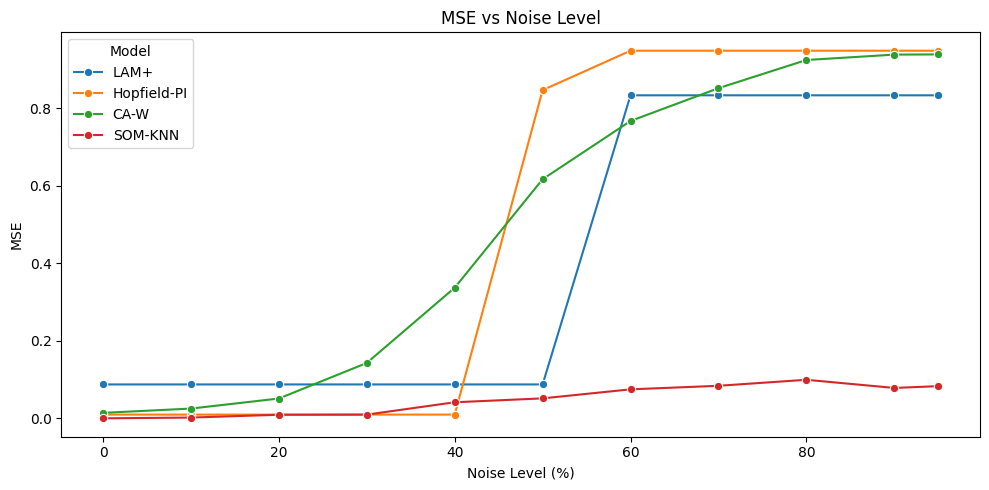

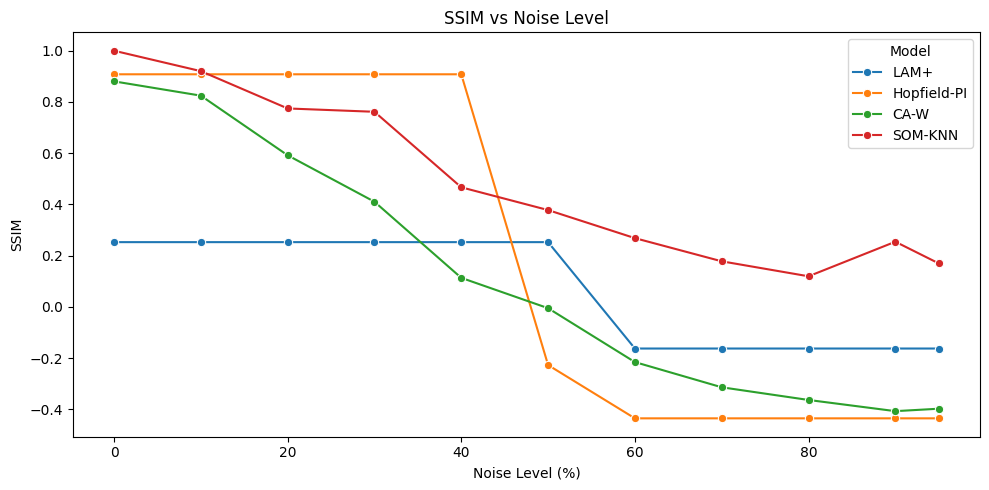

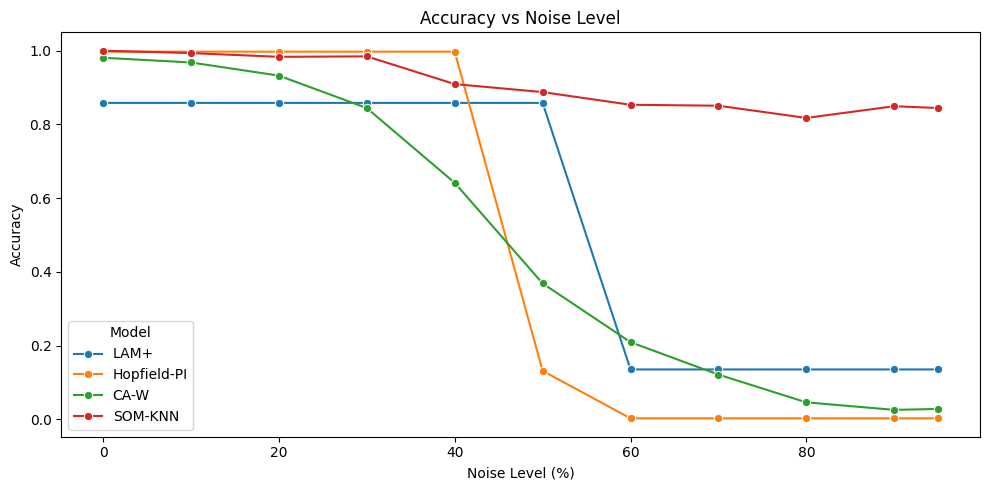

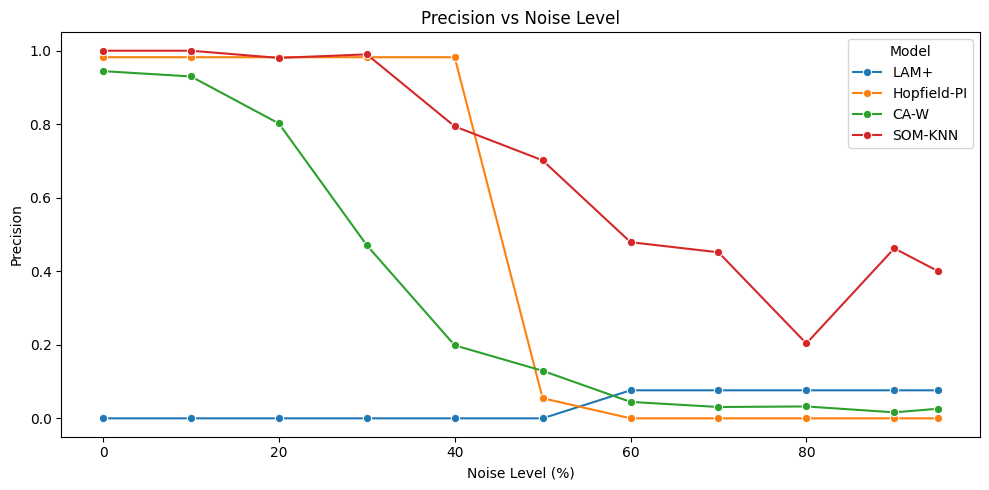

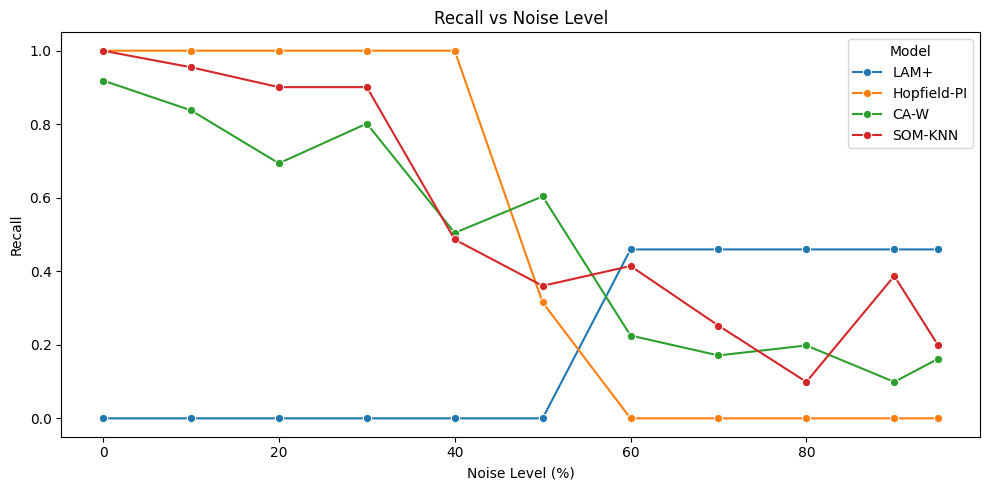

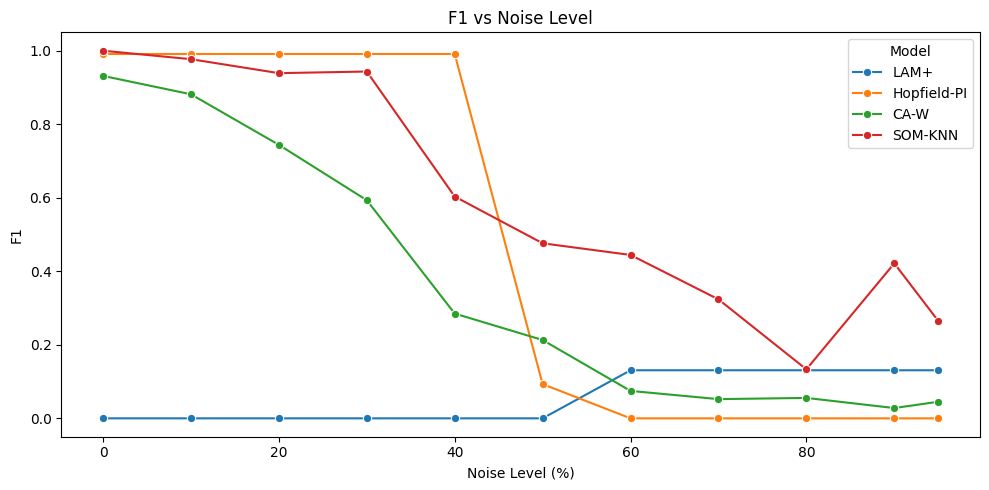

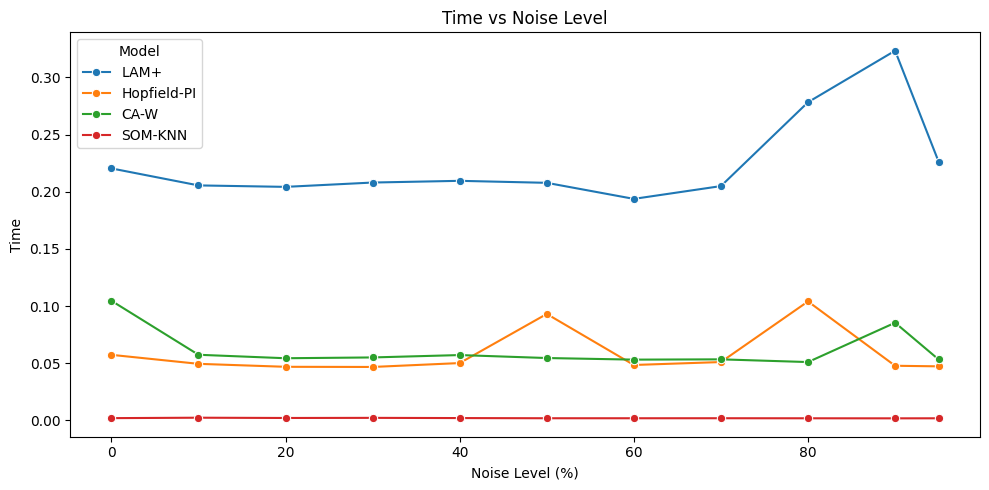

<ipython-input-11-5e22e87fd8a9>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_runtime.values, y=avg_runtime.index, palette="Blues_d")


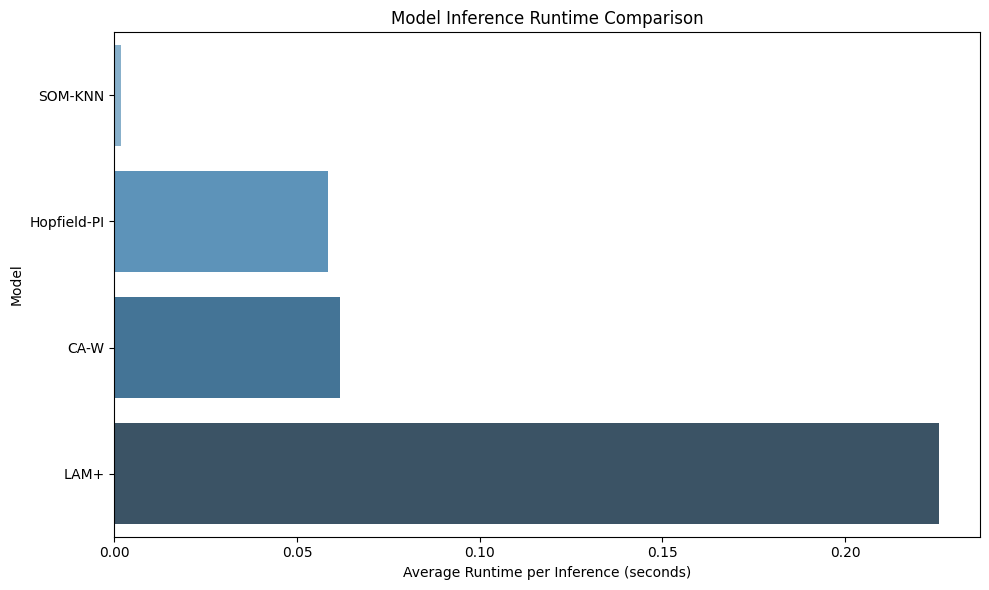

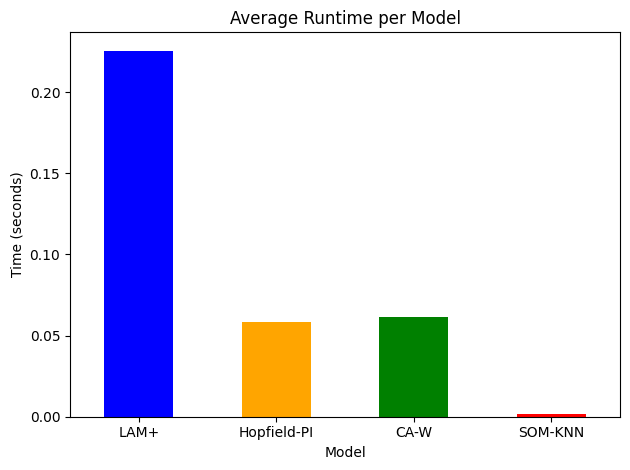

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Raw data as a CSV string
raw_data = """
Model,Noise,MSE,SSIM,Accuracy,Precision,Recall,F1,Time
LAM+,0,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.220391
LAM+,10,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.205515
LAM+,20,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.204234
LAM+,30,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.208022
LAM+,40,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.209520
LAM+,50,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.207772
LAM+,60,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.193728
LAM+,70,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.204914
LAM+,80,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.278287
LAM+,90,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.323348
LAM+,95,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.226226
Hopfield-PI,0,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.057296
Hopfield-PI,10,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.049424
Hopfield-PI,20,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.046825
Hopfield-PI,30,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.046688
Hopfield-PI,40,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.050094
Hopfield-PI,50,8.464292e-01,-0.226996,0.131378,0.054688,0.315315,0.093209,0.093067
Hopfield-PI,60,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.048421
Hopfield-PI,70,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.050984
Hopfield-PI,80,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.104014
Hopfield-PI,90,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.047731
Hopfield-PI,95,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.047226
CA-W,0,1.413634e-02,0.880378,0.980867,0.944444,0.918919,0.931507,0.104608
CA-W,10,2.520077e-02,0.824611,0.968112,0.930000,0.837838,0.881517,0.057353
CA-W,20,5.111113e-02,0.591840,0.932398,0.802083,0.693694,0.743961,0.054321
CA-W,30,1.428428e-01,0.410475,0.844388,0.470899,0.801802,0.593333,0.055016
CA-W,40,3.368654e-01,0.113390,0.641582,0.198582,0.504505,0.284987,0.057094
CA-W,50,6.166273e-01,-0.005005,0.368622,0.129344,0.603604,0.213037,0.054503
CA-W,60,7.668524e-01,-0.215382,0.209184,0.044723,0.225225,0.074627,0.053100
CA-W,70,8.514213e-01,-0.313750,0.121173,0.030844,0.171171,0.052270,0.053351
CA-W,80,9.240953e-01,-0.363260,0.045918,0.032305,0.198198,0.055556,0.050974
CA-W,90,9.379609e-01,-0.406893,0.025510,0.016296,0.099099,0.027990,0.085380
CA-W,95,9.385011e-01,-0.397382,0.028061,0.026201,0.162162,0.045113,0.053220
SOM-KNN,0,1.130402e-11,1.000000,1.000000,1.000000,1.000000,1.000000,0.001918
SOM-KNN,10,2.019934e-03,0.920264,0.993622,1.000000,0.954955,0.976959,0.002294
SOM-KNN,20,9.236540e-03,0.774616,0.983418,0.980392,0.900901,0.938967,0.002054
SOM-KNN,30,9.607851e-03,0.761598,0.984694,0.990099,0.900901,0.943396,0.002158
SOM-KNN,40,4.142824e-02,0.466841,0.909439,0.794118,0.486486,0.603352,0.001979
SOM-KNN,50,5.149354e-02,0.377987,0.887755,0.701754,0.360360,0.476190,0.001822
SOM-KNN,60,7.476681e-02,0.268429,0.853316,0.479167,0.414414,0.444444,0.001814
SOM-KNN,70,8.393830e-02,0.177993,0.850765,0.451613,0.252252,0.323699,0.001832
SOM-KNN,80,9.942559e-02,0.119522,0.817602,0.203704,0.099099,0.133333,0.001786
SOM-KNN,90,7.839344e-02,0.254427,0.849490,0.462366,0.387387,0.421569,0.001739
SOM-KNN,95,8.301499e-02,0.169779,0.844388,0.400000,0.198198,0.265060,0.001782
"""

# Read into a DataFrame
df = pd.read_csv(StringIO(raw_data))

# Plotting setup
metrics = ['MSE', 'SSIM', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
import seaborn as sns
import matplotlib.pyplot as plt

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x='Noise', y=metric, hue='Model', marker='o')
    plt.title(f'{metric} vs Noise Level')
    plt.ylabel(metric)
    plt.xlabel('Noise Level (%)')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

# Simulate reading from a CSV
data = pd.read_csv(StringIO(raw_data.strip()))

# Compute average runtime per model
avg_runtime = data.groupby("Model")["Time"].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_runtime.values, y=avg_runtime.index, palette="Blues_d")
plt.xlabel("Average Runtime per Inference (seconds)")
plt.title("Model Inference Runtime Comparison")
plt.tight_layout()
plt.show()


# Define color mapping
colors = {
    "LAM+": "blue",
    "Hopfield-PI": "orange",
    "CA-W": "green",
    "SOM-KNN": "red"
}

# Plot
#plt.figure(figsize=(8, 5))
mean_runtime.loc[colors.keys()].plot(kind='bar', color=[colors[m] for m in mean_runtime.loc[colors.keys()].index])
plt.title("Average Runtime per Model")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


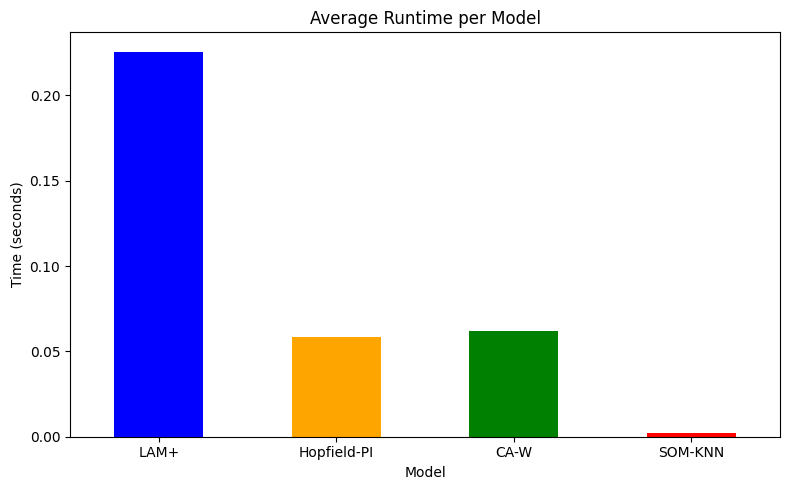

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Raw data
raw_data = """
Model,Noise,MSE,SSIM,Accuracy,Precision,Recall,F1,Time
LAM+,0,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.220391
LAM+,10,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.205515
LAM+,20,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.204234
LAM+,30,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.208022
LAM+,40,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.209520
LAM+,50,8.745837e-02,0.252806,0.858418,0.000000,0.000000,0.000000,0.207772
LAM+,60,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.193728
LAM+,70,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.204914
LAM+,80,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.278287
LAM+,90,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.323348
LAM+,95,8.330606e-01,-0.162441,0.135204,0.076233,0.459459,0.130769,0.226226
Hopfield-PI,0,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.057296
Hopfield-PI,10,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.049424
Hopfield-PI,20,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.046825
Hopfield-PI,30,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.046688
Hopfield-PI,40,9.629538e-03,0.907990,0.997449,0.982301,1.000000,0.991071,0.050094
Hopfield-PI,50,8.464292e-01,-0.226996,0.131378,0.054688,0.315315,0.093209,0.093067
Hopfield-PI,60,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.048421
Hopfield-PI,70,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.050984
Hopfield-PI,80,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.104014
Hopfield-PI,90,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.047731
Hopfield-PI,95,9.480449e-01,-0.434963,0.002551,0.000000,0.000000,0.000000,0.047226
CA-W,0,1.413634e-02,0.880378,0.980867,0.944444,0.918919,0.931507,0.104608
CA-W,10,2.520077e-02,0.824611,0.968112,0.930000,0.837838,0.881517,0.057353
CA-W,20,5.111113e-02,0.591840,0.932398,0.802083,0.693694,0.743961,0.054321
CA-W,30,1.428428e-01,0.410475,0.844388,0.470899,0.801802,0.593333,0.055016
CA-W,40,3.368654e-01,0.113390,0.641582,0.198582,0.504505,0.284987,0.057094
CA-W,50,6.166273e-01,-0.005005,0.368622,0.129344,0.603604,0.213037,0.054503
CA-W,60,7.668524e-01,-0.215382,0.209184,0.044723,0.225225,0.074627,0.053100
CA-W,70,8.514213e-01,-0.313750,0.121173,0.030844,0.171171,0.052270,0.053351
CA-W,80,9.240953e-01,-0.363260,0.045918,0.032305,0.198198,0.055556,0.050974
CA-W,90,9.379609e-01,-0.406893,0.025510,0.016296,0.099099,0.027990,0.085380
CA-W,95,9.385011e-01,-0.397382,0.028061,0.026201,0.162162,0.045113,0.053220
SOM-KNN,0,1.130402e-11,1.000000,1.000000,1.000000,1.000000,1.000000,0.001918
SOM-KNN,10,2.019934e-03,0.920264,0.993622,1.000000,0.954955,0.976959,0.002294
SOM-KNN,20,9.236540e-03,0.774616,0.983418,0.980392,0.900901,0.938967,0.002054
SOM-KNN,30,9.607851e-03,0.761598,0.984694,0.990099,0.900901,0.943396,0.002158
SOM-KNN,40,4.142824e-02,0.466841,0.909439,0.794118,0.486486,0.603352,0.001979
SOM-KNN,50,5.149354e-02,0.377987,0.887755,0.701754,0.360360,0.476190,0.001822
SOM-KNN,60,7.476681e-02,0.268429,0.853316,0.479167,0.414414,0.444444,0.001814
SOM-KNN,70,8.393830e-02,0.177993,0.850765,0.451613,0.252252,0.323699,0.001832
SOM-KNN,80,9.942559e-02,0.119522,0.817602,0.203704,0.099099,0.133333,0.001786
SOM-KNN,90,7.839344e-02,0.254427,0.849490,0.462366,0.387387,0.421569,0.001739
SOM-KNN,95,8.301499e-02,0.169779,0.844388,0.400000,0.198198,0.265060,0.001782
"""

# Create DataFrame
df = pd.read_csv(StringIO(raw_data))

# Calculate mean runtime per model
mean_runtime = df.groupby("Model")["Time"].mean()

# Define color mapping
colors = {
    "LAM+": "blue",
    "Hopfield-PI": "orange",
    "CA-W": "green",
    "SOM-KNN": "red"
}

# Plot
plt.figure(figsize=(8, 5))
mean_runtime.loc[colors.keys()].plot(kind='bar', color=[colors[m] for m in mean_runtime.loc[colors.keys()].index])
plt.title("Average Runtime per Model")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<ipython-input-14-1d5e0d946fae>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


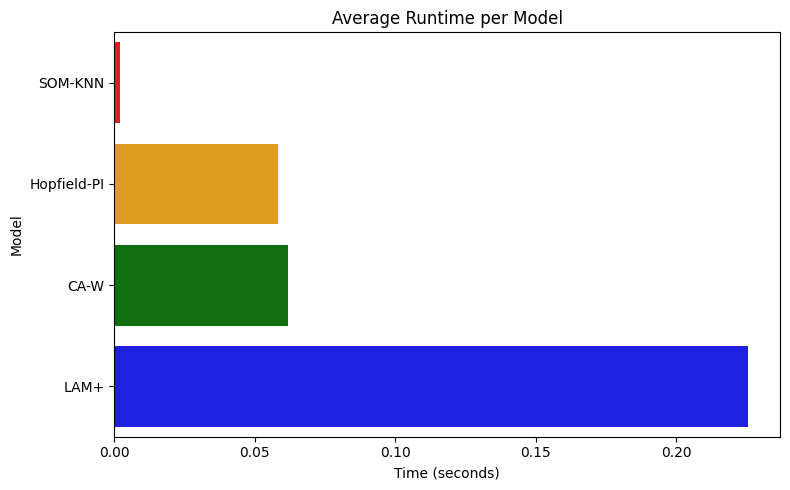

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

# Assuming `raw_data` is a string with CSV content
df = pd.read_csv(StringIO(raw_data))

# Compute mean runtime per model
runtime_means = df.groupby("Model")["Time"].mean().sort_values()

# Define consistent colors using actual model names
palette = {
    "LAM+": "blue",
    "Hopfield-PI": "orange",
    "CA-W": "green",
    "SOM-KNN": "red"
}

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=runtime_means.values,
    y=runtime_means.index,
    palette=[palette.get(model, "gray") for model in runtime_means.index]
)
plt.title("Average Runtime per Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


Evaluation Metrics

In [ ]:
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scipy.stats import linregress

# Placeholder image size (used for reshaping), will be replaced with actual image dimension
IMG = 28

# Store metrics
def evaluate_model(model, x_true, noise_pct, steps=None):
    """
    Evaluate a model's performance at a given noise level.
    Returns performance metrics and recall time.
    """
    x_noisy = add_noise(x_true, noise_pct)
    start = time.time()
    x_rec = model.recall(x_noisy)
    duration = time.time() - start

    # Reshape to image
    rec_img = x_rec.reshape(IMG, IMG)
    true_img = x_true.reshape(IMG, IMG)

    # MSE & SSIM
    mse_val = ((rec_img - true_img)**2).mean()
    ssim_val = ssim(true_img, rec_img, data_range=1)

    # Binarize for classification metrics
    x_rec_bin = (x_rec > 0.5).astype(int)
    x_true_bin = (x_true > 0.5).astype(int)
    acc = accuracy_score(x_true_bin, x_rec_bin)
    prec = precision_score(x_true_bin, x_rec_bin, zero_division=0)
    rec = recall_score(x_true_bin, x_rec_bin, zero_division=0)
    f1 = f1_score(x_true_bin, x_rec_bin, zero_division=0)

    return {
        "MSE": mse_val,
        "SSIM": ssim_val,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Time": duration
    }

def robustness_slope(ssim_scores, noise_levels):
    """Calculate slope of SSIM degradation with noise."""
    slope, _, _, _, _ = linregress(noise_levels, ssim_scores)
    return slope

def find_ssim_threshold_crossing(ssim_scores, noise_levels, threshold=0.5):
    """Return the max noise level at which SSIM stays above threshold."""
    for n, s in zip(noise_levels, ssim_scores):
        if s < threshold:
            return n - 10  # Assume steps of 10
    return max(noise_levels)

def aggregate_over_trials(model, x_true, noise_pct, trials=5):
    results = []
    for _ in range(trials):
        res = evaluate_model(model, x_true, noise_pct)
        results.append(res)
    df = pd.DataFrame(results)
    return df.mean().to_dict(), df.std().to_dict()

# These functions are ready to be integrated into your notebook.
# You can loop through all models and noise levels, collect results, and build summary tables.


In [ ]:
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scipy.stats import linregress

# You can override this if working with larger images later
IMG = 28

# Core evaluation function
def evaluate_model(model, x_true, noise_pct, steps=None):
    x_noisy = add_noise(x_true, noise_pct)
    start = time.time()
    x_rec = model.recall(x_noisy)
    duration = time.time() - start

    rec_img = x_rec.reshape(IMG, IMG)
    true_img = x_true.reshape(IMG, IMG)

    mse_val = ((rec_img - true_img)**2).mean()
    ssim_val = ssim(true_img, rec_img, data_range=1)

    x_rec_bin = (x_rec > 0.5).astype(int)
    x_true_bin = (x_true > 0.5).astype(int)

    return {
        "MSE": mse_val,
        "SSIM": ssim_val,
        "Accuracy": accuracy_score(x_true_bin, x_rec_bin),
        "Precision": precision_score(x_true_bin, x_rec_bin, zero_division=0),
        "Recall": recall_score(x_true_bin, x_rec_bin, zero_division=0),
        "F1": f1_score(x_true_bin, x_rec_bin, zero_division=0),
        "Time": duration
    }


In [ ]:
def aggregate_over_trials(model, x_true, noise_pct, trials=5):
    results = []
    for _ in range(trials):
        res = evaluate_model(model, x_true, noise_pct)
        results.append(res)
    df = pd.DataFrame(results)
    return df.mean().to_dict(), df.std().to_dict()


In [ ]:
def robustness_slope(ssim_scores, noise_levels):
    """Fit a line to SSIM vs noise level."""
    slope, _, _, _, _ = linregress(noise_levels, ssim_scores)
    return slope

def find_ssim_threshold_crossing(ssim_scores, noise_levels, threshold=0.5):
    """Get max noise level with SSIM > threshold."""
    for n, s in zip(noise_levels, ssim_scores):
        if s < threshold:
            return n - 10  # assuming 10% steps
    return max(noise_levels)


In [ ]:
rows = []
for name, model in all_models.items():
    ssim_list = []
    for noise in NOISE_LEVELS:
        mean_metrics, std_metrics = aggregate_over_trials(model, patterns[0], noise)
        ssim_list.append(mean_metrics["SSIM"])
        rows.append({
            "Model": name,
            "Noise": noise,
            **mean_metrics,
            "SSIM_STD": std_metrics["SSIM"]
        })
    # After noise loop
    slope = robustness_slope(ssim_list, NOISE_LEVELS)
    tolerance = find_ssim_threshold_crossing(ssim_list, NOISE_LEVELS)
    print(f"{name}: Slope = {slope:.4f}, Noise Tolerance = {tolerance}%")


Hopfield: Slope = -0.0062, Noise Tolerance = -10%
CA: Slope = -0.0099, Noise Tolerance = 0%
SOM: Slope = -0.0106, Noise Tolerance = 40%
LAM: Slope = -0.0023, Noise Tolerance = -10%
Hopfield+: Slope = -0.0064, Noise Tolerance = -10%
CA+: Slope = -0.0061, Noise Tolerance = -10%
SOM+: Slope = -0.0087, Noise Tolerance = 30%
LAM+: Slope = -0.0058, Noise Tolerance = -10%
Hopfield-PI: Slope = -0.0187, Noise Tolerance = 40%
CA-W: Slope = -0.0146, Noise Tolerance = 20%
SOM-KNN: Slope = -0.0107, Noise Tolerance = 40%
Hybrid2: Slope = -0.0188, Noise Tolerance = 40%


In [ ]:
import pandas as pd

results = []

for name, model in all_models.items():
    ssim_list = []
    for noise in NOISE_LEVELS:
        trial_metrics = []
        for _ in range(3):  # 3 trials for stability
            x_noisy = add_noise(patterns[0], noise)
            start = time.time()
            x_rec = model.recall(x_noisy)
            duration = time.time() - start

            x_true = patterns[0]
            mse = ((x_rec - x_true) ** 2).mean()
            ssim_val = ssim(x_true.reshape(IMG, IMG), x_rec.reshape(IMG, IMG), data_range=1)
            acc = (x_rec.round() == x_true).mean()

            # Binarise for precision/recall
            y_true = x_true.round().astype(int)
            y_pred = x_rec.round().astype(int)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            trial_metrics.append({
                'MSE': mse,
                'SSIM': ssim_val,
                'Accuracy': acc,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Time': duration
            })

        df_trials = pd.DataFrame(trial_metrics)
        means = df_trials.mean()
        stds = df_trials.std()

        results.append({
            'Model': name,
            'Noise': noise,
            **{k: means[k] for k in means.index},
            **{k + '_STD': stds[k] for k in stds.index}
        })

df_metrics = pd.DataFrame(results)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set(style="whitegrid")

# 1. SSIM vs Noise Level for Each Model
def plot_ssim_vs_noise(df):
    plt.figure(figsize=(10, 6))
    for model in df['Model'].unique():
        sub = df[df['Model'] == model]
        plt.plot(sub['Noise'], sub['SSIM'], marker='o', label=model)
    plt.title("SSIM vs Noise Level")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("SSIM")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2. Error Bars for SSIM Stability (Standard Deviation)
def plot_ssim_stability(df):
    plt.figure(figsize=(10, 6))
    for model in df['Model'].unique():
        sub = df[df['Model'] == model]
        plt.errorbar(sub['Noise'], sub['SSIM'], yerr=sub['SSIM_STD'], label=model, capsize=3)
    plt.title("SSIM with Stability Error Bars")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("SSIM")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3. Runtime per Inference per Model
def plot_runtime(df):
    avg_time = df.groupby("Model")["Time"].mean().sort_values()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=avg_time.values, y=avg_time.index, palette="Blues_d")
    plt.title("Average Runtime per Inference")
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

# 4. F1 Score vs Noise
def plot_f1_vs_noise(df):
    plt.figure(figsize=(10, 6))
    for model in df['Model'].unique():
        sub = df[df['Model'] == model]
        plt.plot(sub['Noise'], sub['F1'], marker='s', label=model)
    plt.title("F1 Score vs Noise Level")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Accuracy Heatmap
def plot_accuracy_heatmap(df):
    pivot = df.pivot(index="Model", columns="Noise", values="Accuracy")
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Accuracy Heatmap Across Noise Levels")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


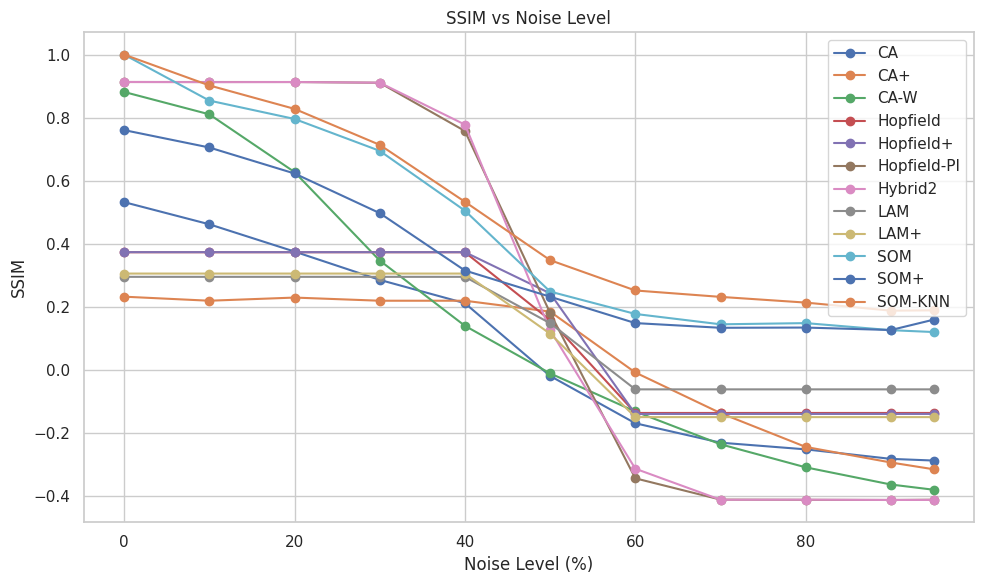

In [ ]:
plot_ssim_vs_noise(df)


In [ ]:
!pip install -q scikit-image matplotlib

from PIL import Image
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def load_image(path, grayscale=False):
    img = Image.open(path)
    if grayscale:
        img = img.convert('L')
        arr = np.array(img).astype(np.float32) / 255.0
        return arr.reshape(1, *arr.shape)  # shape: (1, H, W)
    else:
        arr = np.array(img).astype(np.float32) / 255.0  # shape: (H, W, 3)
        return arr.transpose(2, 0, 1)  # shape: (3, H, W)

cat_rgb = load_image("/content/Cat.jpeg", grayscale=False)
landscape_gray = load_image("/content/Landscape.jpeg", grayscale=True)


In [ ]:
def flatten_image(img):
    return img.flatten()

def add_noise(x, pct):
    x = x.copy()
    n = int(x.size * pct / 100)
    idx = np.random.choice(x.size, n, replace=False)
    flat = x.flatten()
    flat[idx] = 1 - flat[idx]
    return flat.reshape(x.shape)


In [ ]:
def evaluate_model_image(model, x_true, shape, noise_pct):
    x_noisy = add_noise(x_true, noise_pct)
    start = time.time()
    x_rec = model.recall(x_noisy)
    duration = time.time() - start

    x_true_img = x_true.reshape(shape)
    x_rec_img = x_rec.reshape(shape)

    # Binarize for classification metrics
    x_true_bin = (x_true > 0.5).astype(int).flatten()
    x_rec_bin = (x_rec > 0.5).astype(int).flatten()

    return {
        "MSE": ((x_true_img - x_rec_img) ** 2).mean(),
        "SSIM": ssim(x_true_img, x_rec_img, data_range=1, channel_axis=0 if len(shape) == 3 else None),
        "Accuracy": accuracy_score(x_true_bin, x_rec_bin),
        "Precision": precision_score(x_true_bin, x_rec_bin, zero_division=0),
        "Recall": recall_score(x_true_bin, x_rec_bin, zero_division=0),
        "F1": f1_score(x_true_bin, x_rec_bin, zero_division=0),
        "Time": duration
    }


In [ ]:
# Training vector (you can reuse the same vector across models)
cat_vec = flatten_image(cat_rgb).reshape(1, -1)

# Model initialisation
models = {
    "Hopfield-PI": HopfieldPseudoInverse(cat_vec),
    "CA-W": WeightedMajorityCA(),
    "SOM-KNN": SOMKNN(cat_vec),
    "LAM+": LAMEnhanced(HopfieldPseudoInverse(cat_vec), WeightedMajorityCA())
}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.metrics import structural_similarity as ssim
from scipy.stats import linregress
import numpy as np
import time

def evaluate_model_metrics(model, x_true, noise_levels, shape=None):
    ssim_scores, acc_scores = [], []
    results = []

    for noise in noise_levels:
        x_noisy = add_noise(x_true, noise)
        start = time.time()
        x_rec = model.recall(x_noisy)
        duration = time.time() - start

        # Reshape
        if shape:
            x_true_img = x_true.reshape(shape)
            x_rec_img = x_rec.reshape(shape)
        else:
            x_true_img = x_true.reshape(-1)
            x_rec_img = x_rec.reshape(-1)

        mse_val = ((x_rec_img - x_true_img)**2).mean()
        ssim_val = ssim(x_true_img, x_rec_img, data_range=1, channel_axis=0 if len(x_true_img.shape)==3 else None)

        x_true_bin = (x_true > 0.5).astype(int).flatten()
        x_rec_bin = (x_rec > 0.5).astype(int).flatten()

        acc = accuracy_score(x_true_bin, x_rec_bin)
        prec = precision_score(x_true_bin, x_rec_bin, zero_division=0)
        rec = recall_score(x_true_bin, x_rec_bin, zero_division=0)
        f1 = f1_score(x_true_bin, x_rec_bin, zero_division=0)

        ssim_scores.append(ssim_val)
        acc_scores.append(acc)

        results.append({
            "Noise": noise,
            "MSE": mse_val,
            "SSIM": ssim_val,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "Time": duration
        })

    # Slope of SSIM vs noise
    slope, _, _, _, _ = linregress(noise_levels, ssim_scores)

    # Noise tolerance (SSIM > 0.5)
    tolerance_ssim = max([n for n, s in zip(noise_levels, ssim_scores) if s > 0.5], default=-10)
    tolerance_acc = max([n for n, a in zip(noise_levels, acc_scores) if a > 0.8], default=-10)

    return results, slope, tolerance_ssim, tolerance_acc


In [ ]:
noise_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90]
results = []

image_sets = {
    "Easy (MNIST)": (patterns[0], (28, 28)),  # 1 digit from MNIST
    "Medium (Grayscale)": (flatten_image(landscape_gray), landscape_gray.shape),
    "Complex (RGB)": (flatten_image(cat_rgb), cat_rgb.shape)
}

for model_name, model in models.items():
    for image_type, (img_vec, shape) in image_sets.items():
        for noise in noise_levels:
            metrics = evaluate_model_image(model, img_vec, shape, noise)
            results.append({
                "Model": model_name,
                "ImageType": image_type,
                "Noise": noise,
                **metrics
            })

df_eval = pd.DataFrame(results)


In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_eval, x="Noise", y="F1", hue="Model", style="ImageType", markers=True)
plt.title("F1 Score vs Noise Level by Image Complexity")
plt.ylabel("F1 Score")
plt.xlabel("Noise Level (%)")
plt.tight_layout()
plt.show()


In [ ]:
df_eval.to_csv("model_evaluation_noise_vs_complexity.csv", index=False)


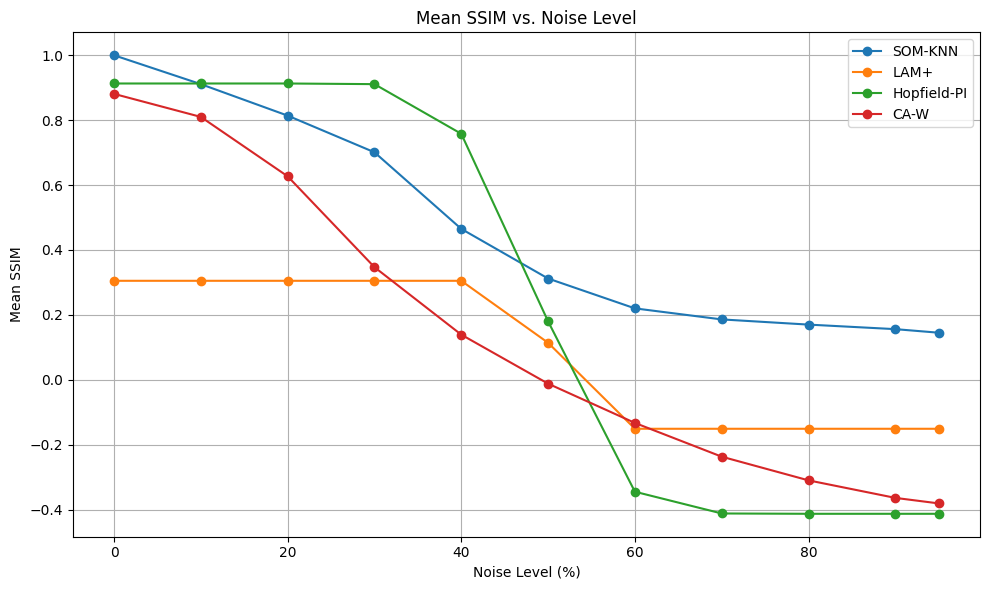

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    "Noise": [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95],
    "CA-W": [0.881, 0.810, 0.627, 0.347, 0.139, -0.012, -0.133, -0.237, -0.310, -0.364, -0.381],
    "Hopfield-PI": [0.913, 0.913, 0.913, 0.911, 0.758, 0.180, -0.345, -0.412, -0.413, -0.413, -0.413],
    "LAM+": [0.305, 0.305, 0.305, 0.305, 0.305, 0.114, -0.151, -0.151, -0.151, -0.151, -0.151],
    "SOM-KNN": [1.000, 0.911, 0.814, 0.701, 0.465, 0.312, 0.220, 0.186, 0.170, 0.156, 0.145]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
for model in ["SOM-KNN", "LAM+", "Hopfield-PI", "CA-W"]:
    plt.plot(df["Noise"], df[model], marker='o', label=model)

plt.title("Mean SSIM vs. Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Mean SSIM")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Description of Figure 8 of Mean SSMI vs Noise level for our four enhanced models. So with no noise, we see that the only model that is 100% accurate in recalling the image is the SOM-KNN, with LAM+ having a recall of 0.3 consistently from noise level 0% to 40% at which point it declines and then plateaus again at around -0.175. Intersetingly, the Hopfield model has the sharpest decline from 40 to 60^ noise level it drops from 0.75 to -0.375 and then ends up being having the lowest simiarity score at just above -0.4 mean SSIM. Simiarly, the cellular automata weighted model is slightly better than the Hopfield better at the highest noise level. But both the enhanced LAM model and the SOMKNN models both decline but not by as much as the other two models the SOMKNN model starts at 1 and drops to 0.175, while the enhanced LAM model starts from 0.3 and ends up at -0.1 at the highest noise level. All of the models experience decline as the level of noise increases which makes logical sense as it becomes more difficult for the model to recall the image when the image is more corrupted, so logically it makes sense.

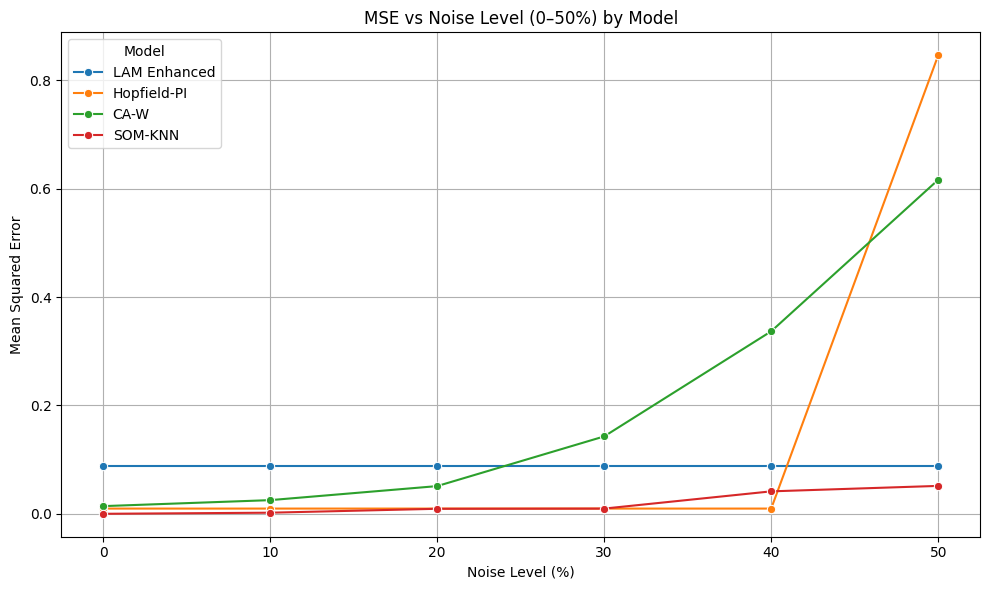

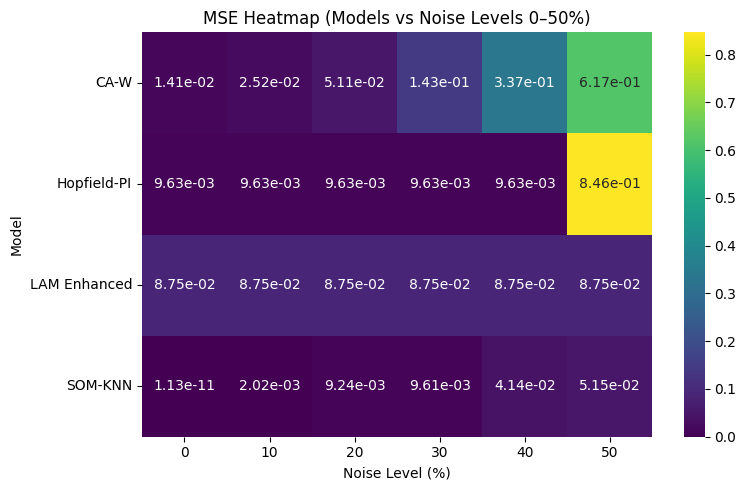

In [ ]:
# Filter data for noise levels from 0 to 50 percent
df_0_to_50 = df[df['Noise'].isin([0, 10, 20, 30, 40, 50])]

# Reuse consistent color palette
palette = sns.color_palette(n_colors=df['Model'].nunique())
model_palette = dict(zip(df['Model'].unique(), palette))

# Line plot from 0 to 50% noise level
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_0_to_50, x='Noise', y='MSE', hue='Model', marker='o', palette=model_palette)
plt.title('MSE vs Noise Level (0–50%) by Model')
plt.ylabel('Mean Squared Error')
plt.xlabel('Noise Level (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap for 0 to 50% noise levels
heatmap_data_0_to_50 = df_0_to_50.pivot(index='Model', columns='Noise', values='MSE')
plt.figure(figsize=(8, 5))
ax = sns.heatmap(heatmap_data_0_to_50, annot=True, fmt=".2e", cmap="viridis")
plt.title('MSE Heatmap (Models vs Noise Levels 0–50%)')
plt.ylabel('Model')
plt.xlabel('Noise Level (%)')

# Rotate y-axis labels to the left (default: already vertical, but this forces it)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
